In [1]:
import tensorflow as tf
import numpy as np
from model_bn import unet
import matplotlib.pyplot as plt
from data import *
import pandas as pd
from datetime import datetime
import keras

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [11]:
scce = tf.keras.metrics.SparseCategoricalCrossentropy()
sca_pre = tf.keras.metrics.SparseCategoricalAccuracy()
sca_usual = tf.keras.metrics.SparseCategoricalAccuracy()
miou = tf.keras.metrics.MeanIoU(num_classes=4)
binsca = tf.keras.metrics.SparseCategoricalAccuracy()
binmiou = tf.keras.metrics.MeanIoU(num_classes=2)
mse = tf.keras.metrics.MeanSquaredError()

In [4]:
test_df = pd.read_csv('transfer_learning_noes/test_data_seed49.csv', index_col=['timestamp', 'num'], parse_dates=['timestamp'])
test_df.head()

,,band1_path,band3_path,hms_path,is_empty_bin,is_empty_den,hms_sum,exists
timestamp,num,,,,,,,
2018-08-23 16:30:00,109,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,True,True,2559909,True
2018-08-14 01:00:00,150,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,True,True,3689832,True
2018-07-28 02:00:00,152,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,True,True,1905,True
2018-08-23 19:00:00,151,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,True,True,4469565,True
2018-07-15 00:00:00,152,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,/n/holyscratch01/mickley_lab/hms_vision_data/5...,True,True,65866,True


In [16]:
band1_gen, band3_gen, hms_gen, val_band1_gen, val_band3_gen, val_hms_gen = train_data_generator(
    dataframe=test_df,
    batch_size=1, image_side_length=512, seed=None, validation_split_rate=0,
    flip=False,
    shuffle=False,
    classify_level='density'
    )
num_img = len(band1_gen)

Found 922 validated image filenames.
Found 922 validated image filenames.
Found 922 validated image filenames.
Found 0 validated image filenames.
Found 0 validated image filenames.
Found 0 validated image filenames.


In [12]:
scce.reset_states()
sca_pre.reset_states()
sca_usual.reset_states()
miou.reset_states()
binsca.reset_states()
binmiou.reset_states()
mse.reset_states()

In [13]:
auto_encoder = True
model = unet(pretrained_weights="transfer_learning_noes/autoencoder49.hdf5", input_size=(512, 512, 2), 
             classify_level=4, auto_encoder=auto_encoder)

In [14]:
auto_encoder = False
model1 = unet(pretrained_weights="transfer_learning_noes/unet49.hdf5", input_size=(512, 512, 2), 
             classify_level=4, auto_encoder=auto_encoder)
model2 = unet(pretrained_weights="transfer_learning_noes/unet_only49.hdf5", input_size=(512, 512, 2), 
             classify_level=4, auto_encoder=auto_encoder)

In [15]:
show_im = False
# break_num = 50
break_num = num_img

In [17]:
for i, (bands, targets) in enumerate(stack_gen(band1_gen, band3_gen, hms_gen, auto_encoder=auto_encoder)):
    # fit
    if i > num_img or i > break_num:
        break
    prediction1 = model1.predict(bands)
    prediction2 = model2.predict(bands)
#         sca.update_state(np.sign(hms), np.sign(prediction_category[0]))
#         print("acc: ", sca.result().numpy())
#         miou.update_state(np.sign(hms[0, :, :, 0]), np.sign(prediction_category[0]))
#         print("miou: ", miou.result().numpy())
#         for lev in range(4):
#             acclev = np.logical_and((hms == lev), (prediction_category == lev)).sum() / hms.size
    # plot
    if auto_encoder:
        mse.update_state(targets, prediction)
        if show_im:
            fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
            ax[0].imshow(bands[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
            ax[0].set_title("band1")
            ax[1].imshow(bands[0, :, :, 1], cmap='gray', vmin=0, vmax=1)
            ax[1].set_title("band3")
            ax[2].imshow(prediction[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
            ax[2].set_title("pred1")
            ax[3].imshow(prediction[0, :, :, 1], cmap='gray', vmin=0, vmax=1)
            ax[3].set_title("pred2")
#             plt.show()
            plt.savefig("example_fig/autoencoderexample{i}.png".format(i=i), dpi=150)
    else:
        sca_pre.update_state(targets, prediction1)
        sca_usual.update_state(targets, prediction2)
        if show_im:
            prediction_category1 = prediction1.argmax(axis=-1)
            prediction_category2 = prediction2.argmax(axis=-1)
            fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(23, 5))
            ax[0].imshow(bands[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
            ax[0].set_title("input (band1)")
            ax[1].imshow(targets[0, :, :, 0], cmap='gray', vmin=0, vmax=3)
            ax[1].set_title("target (HMS)")
            ax[2].imshow(prediction_category1[0], cmap='gray', vmin=0, vmax=3)
            ax[2].set_title("prediction (pre-trained)")
            ax[3].imshow(prediction_category2[0], cmap='gray', vmin=0, vmax=3)
            ax[3].set_title("prediction (pure U-net)")
            plt.savefig("example_fig/outputexample{i}.png".format(i=i), dpi=150)
            print("example_fig/outputexample{i}.png".format(i=i))
            plt.show()

In [18]:
sca_pre.result(), sca_usual.result()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.50966054>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5682609>)

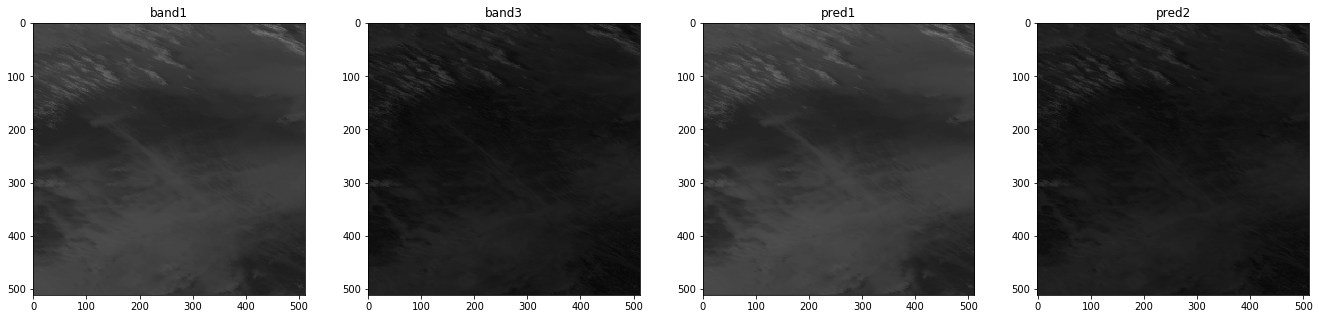

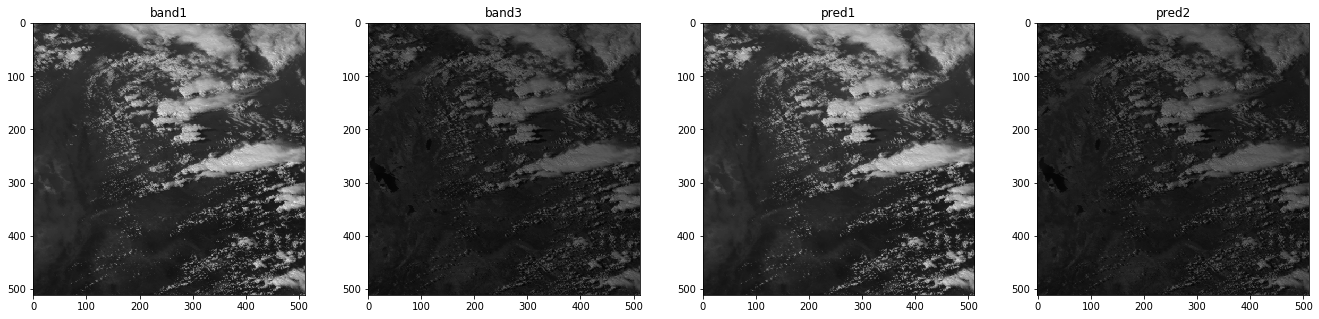

In [36]:
sca_pre.result(), sca_usual

In [27]:
print(mse.result())
print(sca.result())

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.5101448, shape=(), dtype=float32)


In [17]:
auto_encoder = False
model = unet(pretrained_weights="transfer_learning_noes/unet_only49.hdf5", input_size=(512, 512, 2), 
             classify_level=4, auto_encoder=auto_encoder)

In [18]:
sca.reset_states()

In [19]:
for i, (bands, targets) in enumerate(stack_gen(band1_gen, band3_gen, hms_gen, auto_encoder=auto_encoder)):
    if i > 1000:
        break
    else:
        # fit
        prediction = model.predict(bands)
#         sca.update_state(np.sign(hms), np.sign(prediction_category[0]))
#         print("acc: ", sca.result().numpy())
#         miou.update_state(np.sign(hms[0, :, :, 0]), np.sign(prediction_category[0]))
#         print("miou: ", miou.result().numpy())
#         for lev in range(4):
#             acclev = np.logical_and((hms == lev), (prediction_category == lev)).sum() / hms.size
        # plot
        if auto_encoder:
            pass
#             fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 80))
#             ax[0].imshow(bands[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
#             ax[0].set_title("band1")
#             ax[1].imshow(bands[0, :, :, 1], cmap='gray', vmin=0, vmax=1)
#             ax[1].set_title("band3")
#             ax[2].imshow(prediction[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
#             ax[2].set_title("pred1")
#             ax[3].imshow(prediction[0, :, :, 1], cmap='gray', vmin=0, vmax=1)
#             ax[3].set_title("pred2")
#             plt.show()
        else:
            prediction_category = prediction.argmax(axis=-1)
            sca.update_state(targets, prediction)
#             fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 80))
#             ax[0].imshow(bands[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
#             ax[0].set_title("band1")
#             ax[1].imshow(bands[0, :, :, 1], cmap='gray', vmin=0, vmax=1)
#             ax[1].set_title("band3")
#             ax[2].imshow(targets[0, :, :, 0], cmap='gray', vmin=0, vmax=3)
#             ax[2].set_title("HMS")
#             ax[3].imshow(prediction_category[0], cmap='gray', vmin=0, vmax=3)
#             ax[3].set_title("prediction")
#             plt.show()

In [20]:
sca.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.549215>

In [ ]:
acclev = [[], [], [], []]
for i, (bands, hms) in enumerate(stack_gen(band1_gen, band3_gen, hms_gen)):
    prediction = model.predict(bands)
    prediction_category = prediction.argmax(axis=-1)
    sca.update_state(hms, prediction_category[0])
    miou.update_state(hms[0, :, :, 0], prediction_category[0])
    binsca.update_state(np.sign(hms), np.sign(prediction_category[0]))
    binmiou.update_state(np.sign(hms[0, :, :, 0]), np.sign(prediction_category[0]))
    for lev in range(4):
        if (hms == lev).sum() > 0:
            acclev[lev].append(np.logical_and((hms[0, :, :, 0] == lev), (prediction_category[0] == lev)).sum() / (hms[0, :, :, 0] == lev).sum())

In [ ]:
for lev in acclev:
    print(np.mean(np.array(lev)))

In [ ]:
sca.result(), miou.result(), binsca.result(), binmiou.result()

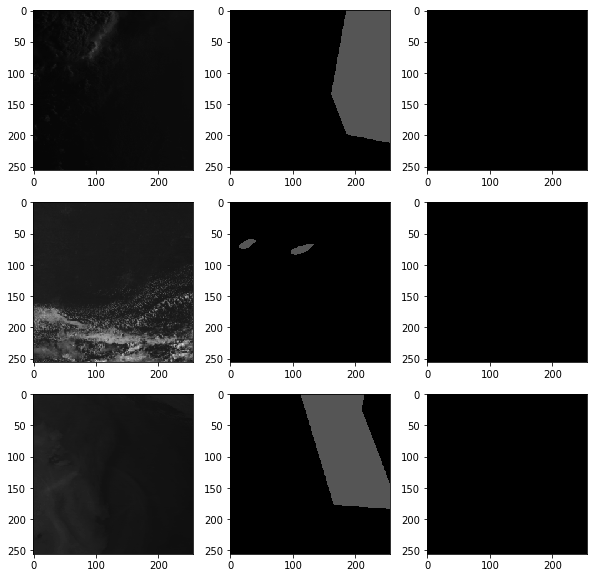

In [7]:
# img_list = []
# imgarr_list = []
# msk_list = []
# imglist = sorted(listdir(goes_path))
# for i in range(3):
#     sample_mask = np.array([0])
#     while not sample_mask.sum() > 0:
#         num = randint(0, 9000)
#         filename = imglist[num]
#         mskpath = path.join(hms_path, filename)
#         sample_mask = np.asarray(Image.open(mskpath))
#     msk_list.append(sample_mask)
#     imgpath = path.join(goes_path, filename)
#     sample_image = Image.open(imgpath)
#     img_list.append(sample_image)
#     imgarr_list.append(np.asarray(sample_image).reshape((-1, 256, 256, 1)) / 255.)
# sample_batch = np.concatenate(imgarr_list, axis=0)
# prediction = model.predict(sample_batch)
# prediction_category = prediction.argmax(axis=-1)\
# fig = plt.figure(figsize=(10,10))
# for i in range(3):
#     im1 = fig.add_subplot(3, 3, i*3+1)
#     im1.imshow(img_list[i], cmap='gray', vmin=0, vmax=255)
#     lb1 = fig.add_subplot(3, 3, i*3+2)
#     lb1.imshow(map_HMS_mask(msk_list[i]), cmap='gray', vmin=0, vmax=3)
#     pd1 = fig.add_subplot(3, 3, i*3+3)
#     pd1.imshow(prediction_category[i], cmap='gray', vmin=0, vmax=3)
# fig.savefig("test_train_result.png", dpi=200)

In [8]:
filelist = [path.join(hms_path, filename) for filename in listdir(hms_path)]

In [9]:
sumlist = np.empty(len(filelist))
for i, file_path in enumerate(filelist):
    image_array = map_HMS_mask(np.asarray(Image.open(file_path)))
    sumlist[i] = image_array.sum()

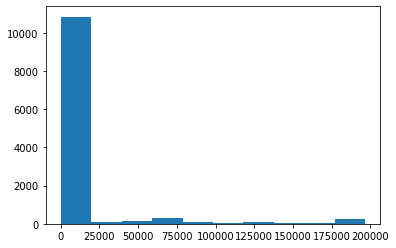

In [11]:
plt.hist(sumlist)
plt.savefig("dist.png", dpi=200)